In [58]:
# Cell 1: Importer les bibliothèques nécessaires
import os
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from PIL import Image
from sklearn.preprocessing import LabelEncoder

Skipping non-image file: A:\Master 1\Help-My-Eyes\object-detection-project\datasets\data_coco\annotations\captions_train2017.json
Skipping non-image file: A:\Master 1\Help-My-Eyes\object-detection-project\datasets\data_coco\annotations\captions_val2017.json
Skipping non-image file: A:\Master 1\Help-My-Eyes\object-detection-project\datasets\data_coco\annotations\instances_train2017.json
Skipping non-image file: A:\Master 1\Help-My-Eyes\object-detection-project\datasets\data_coco\annotations\instances_val2017.json
Skipping non-image file: A:\Master 1\Help-My-Eyes\object-detection-project\datasets\data_coco\annotations\person_keypoints_train2017.json
Skipping non-image file: A:\Master 1\Help-My-Eyes\object-detection-project\datasets\data_coco\annotations\person_keypoints_val2017.json


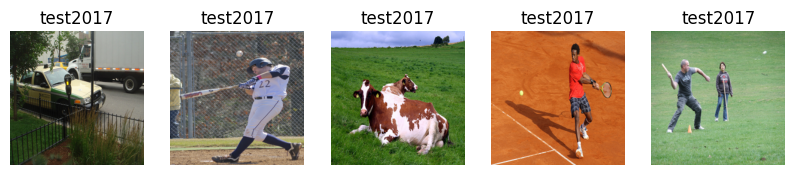

In [59]:
def load_data(data_dir):
    images = []
    labels = []
    for label in os.listdir(data_dir):
        label_dir = os.path.join(data_dir, label)
        for image_file in os.listdir(label_dir):
            image_path = os.path.join(label_dir, image_file)
            if not image_file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
                print(f"Skipping non-image file: {image_path}")
                continue
            try:
                image = preprocess_image(image_path)
                if image is not None and image.shape == (224, 224, 3):
                    images.append(image)
                    labels.append(label)
                else:
                    print(f"Warning: Unable to read image {image_path} or incorrect shape")
            except Exception as e:
                print(f"Warning: Unable to read image {image_path} due to {e}")
    return images, labels

# Fonction pour prétraiter les images
def preprocess_image(image_path):
    try:
        image = Image.open(image_path)
        image = image.resize((224, 224))  # Example resize
        image = np.array(image)
        if image.ndim == 2:  # Convert grayscale to RGB
            image = np.stack((image,)*3, axis=-1)
        elif image.shape[2] == 4:  # Convert RGBA to RGB
            image = image[:, :, :3]
        return image
    except Exception as e:
        print(f"Error processing image {image_path}: {e}")
        return None

# Fonction pour afficher les images
def show_images(images, labels, num=5):
    plt.figure(figsize=(10, 10))
    for i in range(num):
        plt.subplot(1, num, i + 1)
        plt.imshow(images[i])
        plt.title(labels[i])
        plt.axis('off')
    plt.show()

# Charger et afficher les données
data_dir = r'A:\Master 1\Help-My-Eyes\object-detection-project\datasets\data_coco'
images, labels = load_data(data_dir)
show_images(images, labels)

# Encoder les labels en entiers
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)

In [38]:
# Cell 2: Définir le modèle
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

def create_model(input_shape=(224, 224, 3), num_classes=10):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    return model

# Créer et compiler le modèle
model = create_model(num_classes=10)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

a:\Master 1\Help-My-Eyes\Eyes\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_14 (Conv2D)              │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 186624)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 128)            │    23,888,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,908,682 (91.20 MB)

 Trainable params: 23,908,682 (91.20 MB)

 Non-trainable params: 0 (0.00 B)

In [39]:
# Cell 3: Entraîner le modèle
# Diviser les données en ensembles d'entraînement et de validation
images = np.array(images)
labels = np.array(labels)
train_size = int(0.8 * len(images))
train_images, train_labels = images[:train_size], labels[:train_size]
val_images, val_labels = images[train_size:], labels[train_size:]

# Créer des datasets TensorFlow
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels)).shuffle(buffer_size=len(train_images)).batch(32)
val_dataset = tf.data.Dataset.from_tensor_slices((val_images, val_labels)).batch(32)

# Entraîner le modèle
model.fit(train_dataset, epochs=10, validation_data=val_dataset)

Epoch 1/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 489ms/step - accuracy: 0.4027 - loss: 1158.4882 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 2/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 463ms/step - accuracy: 0.5810 - loss: 59.4099 - val_accuracy: 0.9130 - val_loss: 0.3039
Epoch 3/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 463ms/step - accuracy: 0.8829 - loss: 0.6386 - val_accuracy: 0.4783 - val_loss: 3.0699
Epoch 4/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 464ms/step - accuracy: 0.9757 - loss: 0.1844 - val_accuracy: 0.3696 - val_loss: 4.0966
Epoch 5/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 457ms/step - accuracy: 0.9647 - loss: 0.1088 - val_accuracy: 0.6739 - val_loss: 1.7152
Epoch 6/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 462ms/step - accuracy: 1.0000 - loss: 0.0057 - val_accuracy: 0.4565 - val_loss: 3.0426
Epoch 7/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 467ms/step - accuracy: 1.0000 - loss: 0.0010 - val_accuracy: 0.4130 - val_loss: 4.2424
Epoch 8/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 528ms/step - accuracy: 1.0000 - loss: 1.1835e-04 - val_accuracy: 0.4130

In [40]:
# Cell 4: Évaluer le modèle
# Diviser les données en ensembles d'entraînement et de test
test_images, test_labels = images[train_size:], labels[train_size:]

# Créer un dataset TensorFlow pour le test
test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_labels)).batch(32)

# Évaluer le modèle
loss, accuracy = model.evaluate(test_dataset)
print(f'Test Loss: {loss}')
print(f'Test Accuracy: {accuracy}')

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.4524 - loss: 5.4897 
Test Loss: 5.912577152252197
Test Accuracy: 0.41304346919059753


In [41]:
# Cell 5: Améliorer le modèle
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Définir les callbacks pour l'entraînement
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.0001)

# Entraîner le modèle avec les callbacks
model.fit(train_dataset, epochs=50, validation_data=val_dataset, callbacks=[early_stopping, reduce_lr])

Epoch 1/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 470ms/step - accuracy: 1.0000 - loss: 2.7235e-06 - val_accuracy: 0.4130 - val_loss: 6.0677 - learning_rate: 0.0010
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 457ms/step - accuracy: 1.0000 - loss: 8.4123e-07 - val_accuracy: 0.4130 - val_loss: 6.1461 - learning_rate: 0.0010
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 458ms/step - accuracy: 1.0000 - loss: 4.7909e-07 - val_accuracy: 0.4130 - val_loss: 6.1851 - learning_rate: 0.0010
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 467ms/step - accuracy: 1.0000 - loss: 4.7689e-07 - val_accuracy: 0.4130 - val_loss: 6.2010 - learning_rate: 0.0010
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 494ms/step - accuracy: 1.0000 - loss: 2.2392e-07 - val_accuracy: 0.4130 - val_loss: 6.2021 - learning_rate: 2.0000e-04
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 523ms/step - accuracy: 1.0000 - loss: 2.8576e-07 - val_accuracy: 0.4130 - val_loss: 6.2023 - learning_rate: 2.0000e-04


In [50]:
# Cell 7: Déployer le modèle
import os
import threading
from flask import Flask, request, jsonify
from tensorflow.keras.models import load_model

# Créer le répertoire de sauvegarde s'il n'existe pas
save_dir = 'path_to_save_model'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# Enregistrer le modèle
model.save(os.path.join(save_dir, 'model.keras'))  # Utilisez une extension valide

# Déployer le modèle (par exemple, en créant une API avec Flask)
app = Flask(__name__)
model = load_model(os.path.join(save_dir, 'model.keras'))

@app.route('/predict', methods=['POST'])
def predict():
    data = request.json
    image = np.array(data['image']).reshape((1, 224, 224, 3))
    prediction = model.predict(image)
    return jsonify({'prediction': prediction.tolist()})

def run_flask():
    app.run(debug=True, use_reloader=False)

# Exécuter Flask dans un thread séparé
flask_thread = threading.Thread(target=run_flask)
flask_thread.start()

 * Serving Flask app '__main__'
 * Debug mode: on


 * Running on http://127.0.0.1:5000
Press CTRL+C to quit


In [49]:
import requests
import numpy as np

# URL de l'API Flask
url = 'http://127.0.0.1:5000/predict'

# Exemple d'image (remplacez par une image réelle)
image = np.random.rand(224, 224, 3).tolist()

# Envoyer une requête POST à l'API Flask
response = requests.post(url, json={'image': image})

# Afficher la réponse
print(response.json())

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


127.0.0.1 - - [23/Jan/2025 00:10:05] "POST /predict HTTP/1.1" 200 -


{'prediction': [[0.335365891456604, 0.28311991691589355, 0.03428216651082039, 0.03939692676067352, 0.04367673397064209, 0.0673636943101883, 0.05791094899177551, 0.04047369211912155, 0.049945052713155746, 0.04846491292119026]]}
